In [42]:
!pip install -U transformers
!pip install sentencepiece
!pip install rouge
!pip install nltk
import torch
import nltk
nltk.download('punkt')
import json
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig
from rouge import Rouge
import torch
import json
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
import numpy as np
import pandas as pd

In [44]:
news_data=pd.read_csv('news_summary.csv',encoding='latin')

In [45]:
news_data.head(1)

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...


In [46]:
news_data = news_data[['text','ctext']]

In [47]:

news_data.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [48]:
news_data.shape

(4514, 2)

In [49]:
news_data = news_data.head(100)

In [50]:
print(news_data.shape)

(100, 2)


In [51]:
news_data.rename(columns={'ctext': 'complete_text'}, inplace=True)
news_data.rename(columns={'text': 'summary'}, inplace=True)

In [52]:
news_data.head()

,summary,complete_text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [53]:
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')
device = torch.device('cpu')

In [54]:
text = news_data['complete_text'][0]
actual_summary =news_data['summary'][0]
print('Text:',text,'\n')
print('Summary:',actual_summary)

Text: The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory?s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace.?It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues,? the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications ? one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate (right) ? were issued by the

In [55]:
def preprocess_text(text):
    # Replace the special characters with the correct quotation marks
    text = text.replace("?", '"').replace("?", "'")

    # Remove the extra spaces and newlines
    text = text.strip().replace("\n", " ")

    # Add a period at the end of the text if it is missing
    if not text.endswith("."):
        text = text + "."

    # Prepend the text with the prefix "summarize: " to indicate the task to the model
    t5_prepared_Text = "summarize: " + text

    return t5_prepared_Text

In [56]:
t5_prepared_Text = preprocess_text(text)

print ("\n Preprocessed Text: \n", t5_prepared_Text)

tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)

summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=3,
                                    min_length=30,
                                    max_length=200,
                                    length_penalty=2.0,
                                    temperature=0.8)


generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print ("\n\n Generated Summary: \n",generated_summary)

print('\n\n Actual Summary: \n',actual_summary)


 Preprocessed Text: 
 summarize: The Daman and Diu administration on Wednesday withdrew a circular that asked women staff to tie rakhis on male colleagues after the order triggered a backlash from employees and was ripped apart on social media.The union territory"s administration was forced to retreat within 24 hours of issuing the circular that made it compulsory for its staff to celebrate Rakshabandhan at workplace."It has been decided to celebrate the festival of Rakshabandhan on August 7. In this connection, all offices/ departments shall remain open and celebrate the festival collectively at a suitable time wherein all the lady staff shall tie rakhis to their colleagues," the order, issued on August 1 by Gurpreet Singh, deputy secretary (personnel), had said.To ensure that no one skipped office, an attendance report was to be sent to the government the next evening.The two notifications " one mandating the celebration of Rakshabandhan (left) and the other withdrawing the mandate 

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(




 Generated Summary: 
 a circular that asked women staff to tie rakhis on male colleagues triggered a backlash . the union territory"s administration was forced to retreat within 24 hours of issuing the circular . it was withdrawn through a one-line order issued late in the evening by the UT's department of personnel and administrative reforms .


 Actual Summary: 
 The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.


In [57]:
rouge = Rouge()
scores = rouge.get_scores(generated_summary, actual_summary)
print("ROUGE Score:")
print("Precision: {:.3f}".format(scores[0]['rouge-1']['p']))
print("Recall: {:.3f}".format(scores[0]['rouge-1']['r']))
print("F1-Score: {:.3f}".format(scores[0]['rouge-1']['f']))
print(scores)

ROUGE Score:
Precision: 0.500
Recall: 0.438
F1-Score: 0.467
[{'rouge-1': {'r': 0.4375, 'p': 0.5, 'f': 0.46666666168888893}, 'rouge-2': {'r': 0.2033898305084746, 'p': 0.24, 'f': 0.22018348127262027}, 'rouge-l': {'r': 0.4166666666666667, 'p': 0.47619047619047616, 'f': 0.44444443946666673}}]


In [58]:
from nltk.translate.bleu_score import sentence_bleu

def summary_to_sentences(summary):
    # Split the summary into sentences using the '.' character as a separator
    sentences = summary.split('.')

    # Convert each sentence into a list of words
    sentence_lists = [sentence.split() for sentence in sentences]

    return sentence_lists

def paragraph_to_wordlist(paragraph):
    # Split the paragraph into words using whitespace as a separator
    words = paragraph.split()
    return words

reference_paragraph = actual_summary
reference_summary = summary_to_sentences(reference_paragraph)

predicted_paragraph = generated_summary
predicted_summary = paragraph_to_wordlist(predicted_paragraph)

score = sentence_bleu(reference_summary, predicted_summary)
print(score)

0.19940430225921654


In [59]:
print("BLEU Score: {:.3f}".format(score))

BLEU Score: 0.199


In [60]:
def summerize(text):
    t5_prepared_Text = preprocess_text(text)
    tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)
    summary_ids = model.generate(tokenized_text,
                                    num_beams=4,
                                    no_repeat_ngram_size=3,
                                    min_length=30,
                                    max_length=200,
                                    length_penalty=2.0,
                                    temperature=0.8)
    output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return output

In [61]:
Actual_summaries = news_data["summary"].tolist()
Generated_summaries = [summerize(text) for text in news_data["complete_text"]]

In [62]:
rouge = Rouge()
scores = rouge.get_scores(Actual_summaries,Generated_summaries,avg=True)
print("ROUGE Score:")
# print("Precision: {:.3f}".format(scores['rouge-1']['p']))
# print("Recall: {:.3f}".format(scores['rouge-1']['r']))
# print("F1-Score: {:.3f}".format(scores['rouge-1']['f']))
print(scores)

ROUGE Score:
{'rouge-1': {'r': 0.4023489159447536, 'p': 0.30983725553544966, 'f': 0.3464975271400485}, 'rouge-2': {'r': 0.16250045668822144, 'p': 0.1252346204203476, 'f': 0.13961994470915232}, 'rouge-l': {'r': 0.3678262762391965, 'p': 0.2834151557624287, 'f': 0.3168858700920147}}


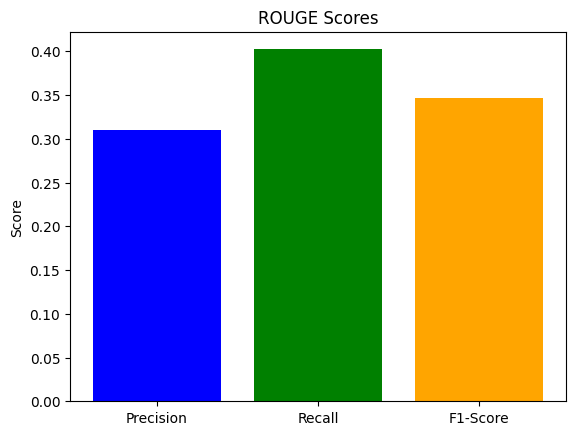

In [63]:
import matplotlib.pyplot as plt

# ROUGE scores
precision = scores['rouge-1']['p']
recall = scores['rouge-1']['r']
f1_score = scores['rouge-1']['f']

# Bar chart
labels = ['Precision', 'Recall', 'F1-Score']
scores_values = [precision, recall, f1_score]

plt.bar(labels, scores_values, color=['blue', 'green', 'orange'])
plt.title('ROUGE Scores')
plt.ylabel('Score')
plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


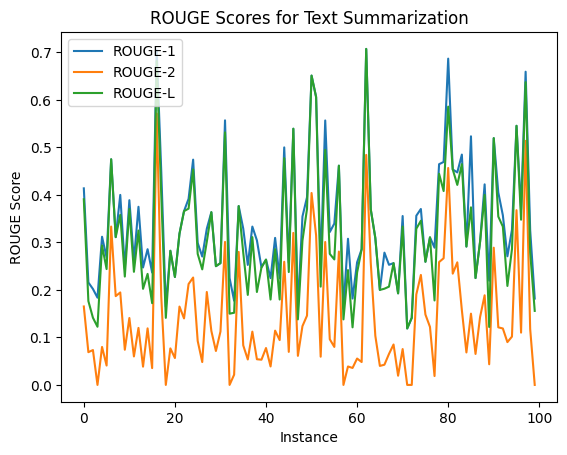

In [64]:
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from rouge import Rouge
import matplotlib.pyplot as plt

# Load your dataset
news_data = pd.read_csv('news_summary.csv', encoding='latin')
news_data = news_data[['text', 'ctext']]
news_data = news_data.head(100)

# Initialize the T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')
device = torch.device('cpu')

# Initialize Rouge
rouge = Rouge()

# Lists to store ROUGE scores
rouge_1_scores = []
rouge_2_scores = []
rouge_l_scores = []

# Loop over each instance in the dataset
for i in range(len(news_data)):
    text = news_data['ctext'][i]
    actual_summary = news_data['text'][i]

    # Preprocess the text
    t5_prepared_Text = "summarize: " + text
    tokenized_text = tokenizer.encode(t5_prepared_Text, return_tensors="pt").to(device)

    # Generate summary
    summary_ids = model.generate(tokenized_text, num_beams=4, no_repeat_ngram_size=3, min_length=30, max_length=200,
                                length_penalty=2.0, temperature=0.8)
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Calculate ROUGE scores
    scores = rouge.get_scores(generated_summary, actual_summary)

    # Store ROUGE scores
    rouge_1_scores.append(scores[0]['rouge-1']['f'])
    rouge_2_scores.append(scores[0]['rouge-2']['f'])
    rouge_l_scores.append(scores[0]['rouge-l']['f'])

# Plotting
plt.plot(rouge_1_scores, label='ROUGE-1')
plt.plot(rouge_2_scores, label='ROUGE-2')
plt.plot(rouge_l_scores, label='ROUGE-L')

# Customize the plot as needed
plt.xlabel('Instance')
plt.ylabel('ROUGE Score')
plt.title('ROUGE Scores for Text Summarization')
plt.legend()
plt.show()